<img src='http://linked.earth/FROGS/images/Pyrateslogo.jpg' width="400">

# PyRATES: Signal Processing

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751), University of Southern California

## Preamble
Often timeseries have to be treated prior to analysis. This is a delicate game:  altering data is a cardinal sin, so one needs to be very aware of one's doing prior to engaging in this activity. Here we show a few examples where such treatment may be warranted.

### Goals

* Become familiar with the various filtering methods and some of their arguments
* Become familiar with the various detrending methods and some of their arguments 

**Reading Time: 20 min**

### Keywords
Filtering, Detrending.  

### Pre-requisites
Some timeseries analysis, ideally 

### Relevant Packages
pyleoclim, pandas, matplotlib, numpy

Let us first load necessary packages:

In [2]:
import matplotlib.pyplot as plt
import pyleoclim as pyleo
import numpy as np
import pandas as pd

## Filtering

The goal of filtering is to enhance part of a signal, or suppress one or more parts. `Pyleoclim` incorporates a [vast array of filters](https://pyleoclim-util.readthedocs.io/en/master/core/api.html?highlight=lipd#pyleoclim.core.series.Series.filter), some inherited from the SciPy library.  To filter a `Series` object, simply apply the `.filter()` method. One innovation of our package is that is makes it easy to specify either a cutoff scale (period) or a cutoff frequency.  

Let's use data fron a Hawai'i seismogram and isolate certain oscillations.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='time [s]', ylabel='amplitude (m)'>)

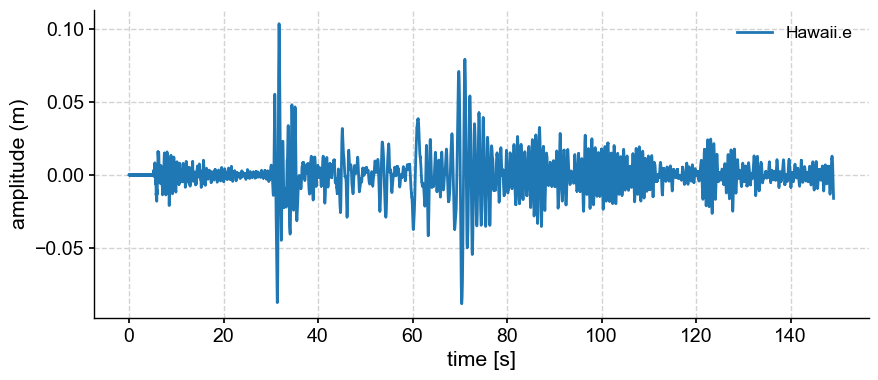

In [39]:
df = pd.read_csv('../data/hawaii.e.dat',sep='\s+',names=['time','ground_motion'])
gm = pyleo.Series(time = df['time']/1000,time_unit='s',
                  value = df['ground_motion']*1000, value_name = 'amplitude (m)',
                  label = 'Hawaii.e',
                  auto_time_params=False,
                  verbose=False)
gm.plot()

## Filter Types

### Lowpass filter
Let's use a Butterworth filter with a `cutoff_scale` of 5 to remove all frequencies with a period of less than 5s. This is known as a **low-pass filter**. 


In [40]:
gm_low = gm.filter(cutoff_scale=5)
fig, ax = gm.plot()
gm_low.plot(ax=ax,label=gm.label + ' (5s lowpass)')

ValueError: This  method assumes evenly-spaced timeseries, while the input is not. Use the ".interp()", ".bin()" or ".gkernel()" methods prior to ".filter()".

Ooops. We got an error message. It must be that the time axis is uneven. Let's use the [resolution()](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.resolution) function to visualize what's happening.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='time [s]', ylabel='resolution [s]'>)

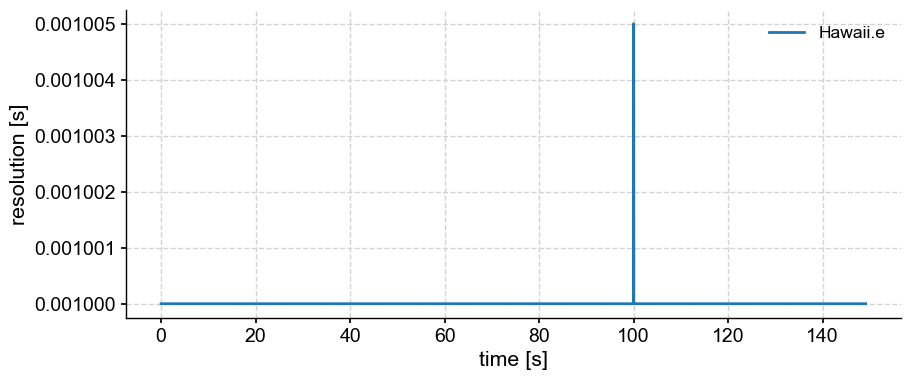

In [41]:
gm.resolution().plot()

It appears that the resolution jumps at the 100th second, for some reason. Let's interpolate to get an even resolution of 1ms, and check that nothing crazy is happening:

<Axes: xlabel='time [s]', ylabel='amplitude (m)'>

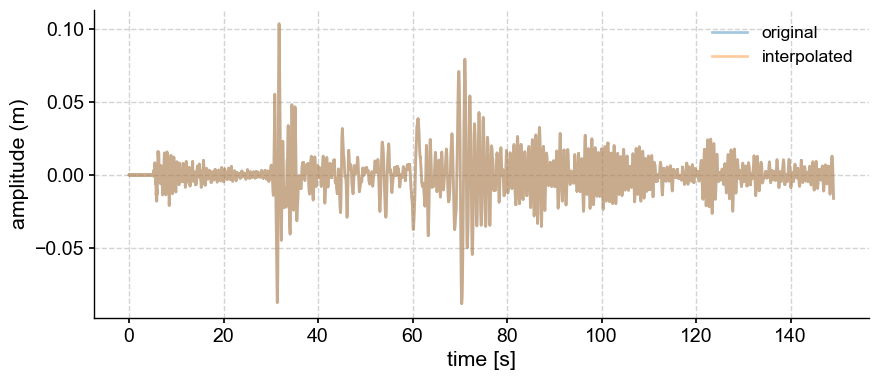

In [42]:
ts = gm.interp(step=0.001)
fig, ax = gm.plot(label='original',alpha=0.4)
ts.plot(ax=ax, label='interpolated',alpha=0.4)

The two series are indistinguishable, so we are safe to proceed.

<Axes: xlabel='time [s]', ylabel='amplitude (m)'>

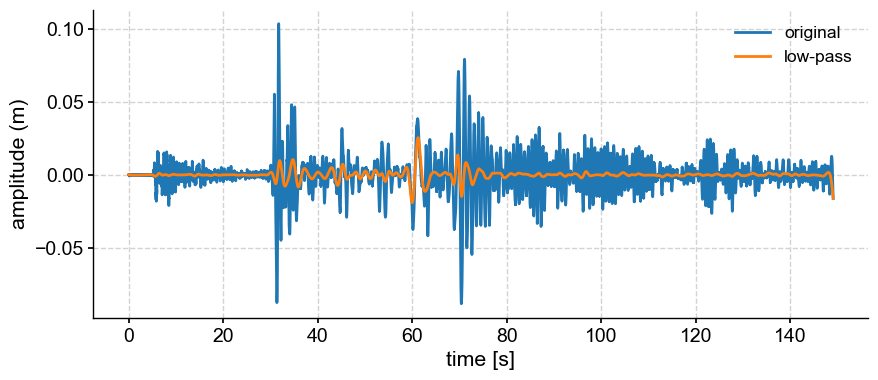

In [15]:
lp = ts.filter(cutoff_scale=2)
fig, ax = ts.plot(label='original')
lp.plot(ax=ax, label='low-pass')

One can see edge effects at the end of the series. This is because the series starts and ends with different values. [Tapering](https://docs.obspy.org/master/packages/autogen/obspy.core.trace.Trace.taper.html) would mitigate that.

<Axes: xlabel='time [s]', ylabel='amplitude (m)'>

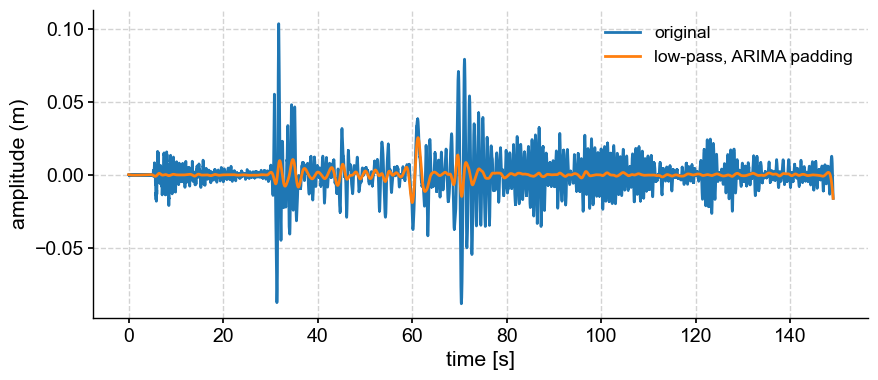

In [37]:
lpa = ts.filter(cutoff_scale=2, pad='ARIMA')  # DOES NOT WORK
fig, ax = ts.plot(label='original')
lpa.plot(ax=ax, label='low-pass, ARIMA padding')


### High-pass filter
The opposite operation is a **high-pass** filter, which keeps only frequencies higher than a given cutoff. To generate a high-pass filter, you can simply subtract the low-pass filtered version from the original: 

<Axes: xlabel='time [s]', ylabel='amplitude (m)'>

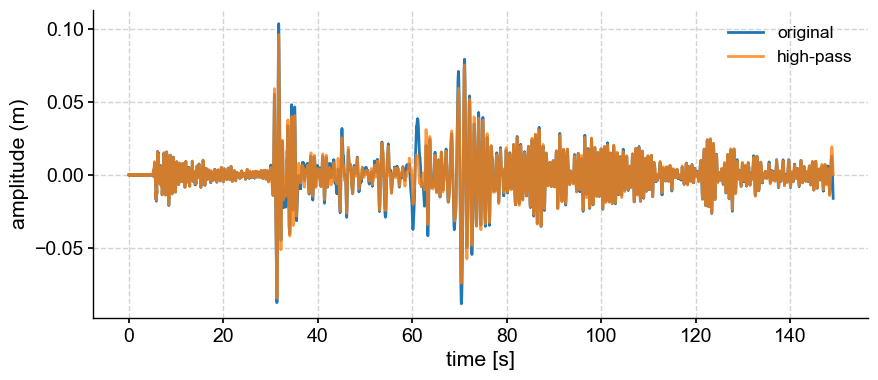

In [20]:
hp = lp.copy() # copy the series into a new object
hp.value = ts.value - lp.value
fig, ax = ts.plot(label='original')
hp.plot(ax=ax, label='high-pass', alpha=0.8)

### Band-pass filter
If you want to isolate variability in a band of frequencies (say 1-2s), simply pass a 2-list of cutoff scales:


<Axes: xlabel='time [s]', ylabel='amplitude (m)'>

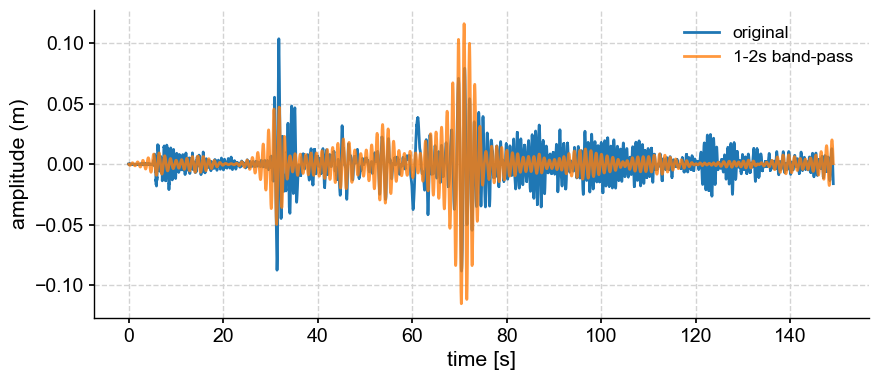

In [21]:
bp = ts.filter(cutoff_scale=[1,2])
fig, ax = ts.plot(label='original')
bp.plot(ax=ax, label='1-2s band-pass', alpha=0.8)

### Notch filter

Conversely, if you wanted to remove all variability between 1-2s (a **notch** in frequency space), you would subtract the bandpass-filtered version.

<Axes: xlabel='time [s]', ylabel='amplitude (m)'>

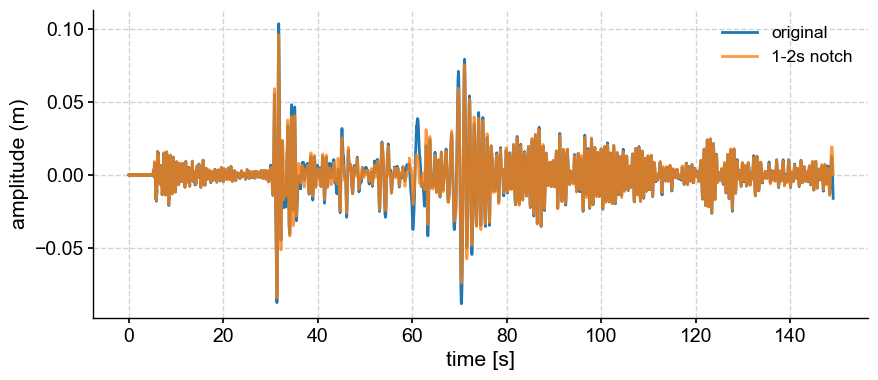

In [22]:
notch = bp.copy() # copy the series into a new object
notch.value = ts.value - bp.value
fig, ax = ts.plot(label='original')
hp.plot(ax=ax, label='1-2s notch', alpha=0.8)

## Window Carpentry

In the above we only used the default method (Butterworth) to generate the filter coefficient. SciPy's [Finite Impulse Response function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html) makes it easy to apply many different types of windows, 

In [1]:
# from scipy import signal
# windows = ['boxcar','triang','blackman','lanczos']
# fig, axs = plt.subplots(4,2,figsize=(10,8))
# Nx = 31

# for i, win in enumerate(windows):
#     win_dow = signal.get_window(win,Nx)
#     axs[i,0].plot(win_dow, label = win + ' window')
#     filt = ts.filter(cutoff_scale=2, method='firwin',window=win)
#     ts.plot(ax=axs[i,1],label='original',xlabel='')
#     filt.plot(ax=axs[i,1],label='2s lowpass, '+win,xlabel='')

## Detrending

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year C.E.]', ylabel='GMST [$^{\\circ}$C]'>)

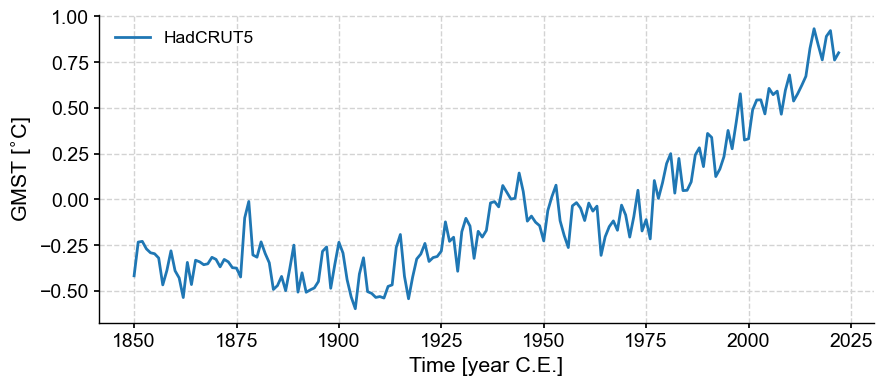

In [4]:
gmst = pyleo.utils.load_dataset('HadCRUT5')
gmst.plot()

The "trend" here is complex, and likely nonlinear. If we wanted to describe it linearly, one would have to distinguish 4 periods: cooling in the late 19th century, warming from 1900 to 1940, cooling from 1940 to 1970, followed by steady warming.  

### Built-in detrending methods in `Pyleoclim`

Let's apply 3 methods using their default parameters: linear detrending, empirical mode decomposition, and a Savitzky-Golay filter, which is meant to isolate the lowest-order trend:

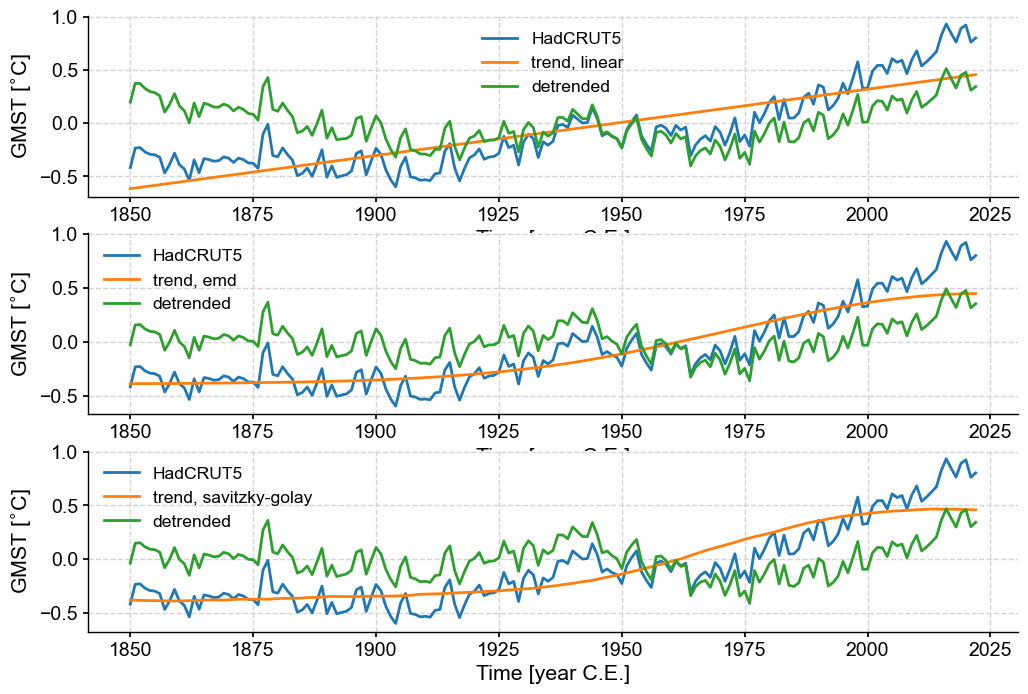

In [18]:
methods  = ['linear', 'emd', 'savitzky-golay']
fig, axs = plt.subplots(3,1,figsize=(12,8))
axs= axs.flatten()
for i, mthd in enumerate(methods):
    gmst_dtd = gmst.detrend(method=mthd,keep_log=True)
    trend = gmst.copy()
    trend.value = gmst_dtd.log[0]['previous_trend'] # retrieve the trend from the log    
    gmst.plot(ax=axs[i])
    trend.plot(ax=axs[i],label='trend, ' + mthd)
    gmst_dtd.plot(ax=axs[i], label='detrended')

The linear trend here does a decent job at capturing first-order behavior, but the two nonlinear methods are out to lunch. Savitzky-Golay does not have a tuning knob, so that's that. However, EMD does allow you to pick different modes ($n=1$ is the default). 

### Tweaking parameters
Let's try modes 1-4 ($n=0, 1 ,2 ,3$) and see which fits best.

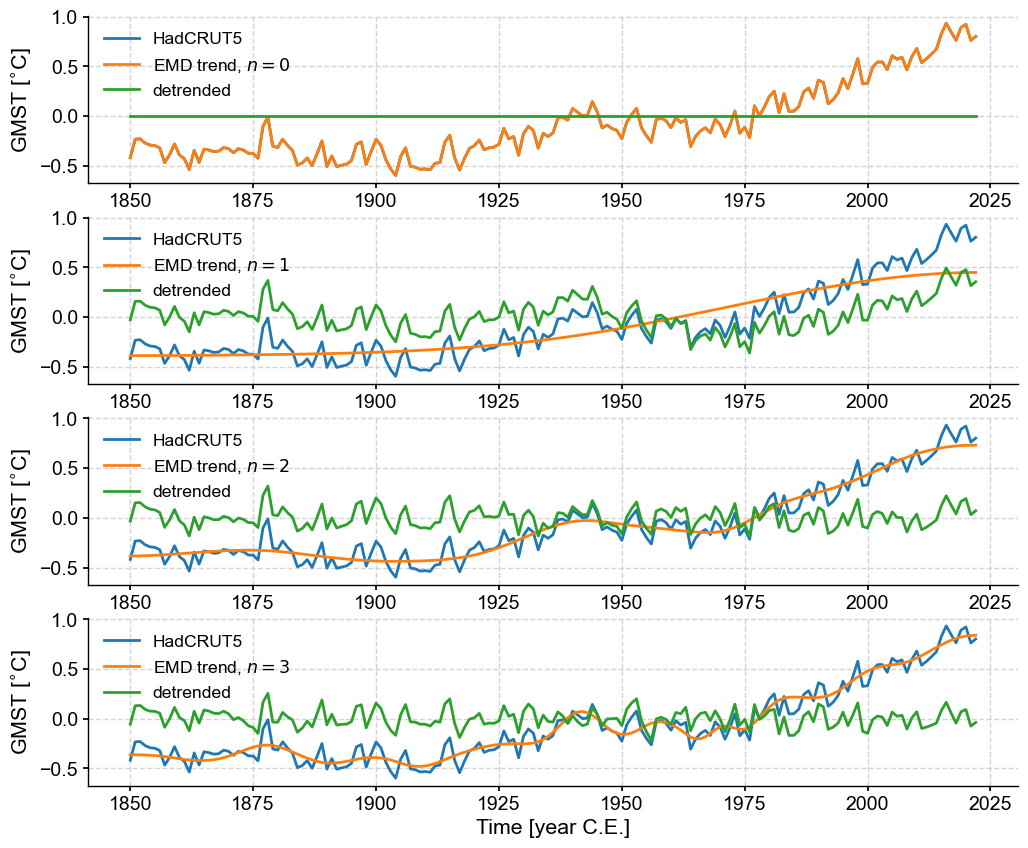

In [21]:
fig, axs = plt.subplots(4,1,figsize=(12,10))
axs= axs.flatten()
for n in range(4):
    gmst_dtd = gmst.detrend(method='emd',n=n,keep_log=True)
    trend = gmst.copy()
    trend.value = gmst_dtd.log[0]['previous_trend'] # retrieve the trend from the log    
    gmst.plot(ax=axs[n])
    trend.plot(ax=axs[n],label=rf'EMD trend, $n={n}$')
    gmst_dtd.plot(ax=axs[n], label='detrended')

The choice is subjective, but it would be reasonable to pick $n=2$ as characterizing the low-order nonlinear trend. This flexibility of EMD is the reason why it is the default choice in `Pyleoclim`.

### SSA detrending

Another option to isolate a non-linear trend is [Singular Spectrum Analysis](http://linked.earth/PyleoTutorials/notebooks/L2_singular_spectrum_analysis.html). If there is a prominent trend, it is often the first mode coming out of that analysis. Let's see this:

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'SSA scree plot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

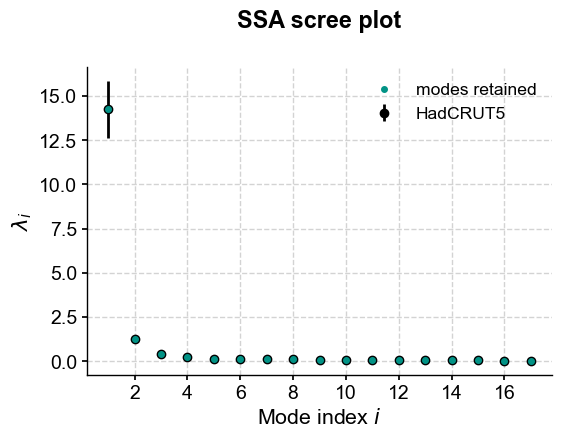

In [25]:
gmst_ssa = gmst.ssa()
gmst_ssa.screeplot()

Indeed, the first mode accounts for an overwhelming fraction of the variance: 

In [29]:
print("{:.2f}".format(gmst_ssa.pctvar[0])+'%')

83.35%


This is what the mode looks like:

(<Figure size 1000x500 with 3 Axes>,
 <Axes: title={'center': 'RC Spectrum (mtm)'}, xlabel='Period [year]', ylabel='PSD'>)

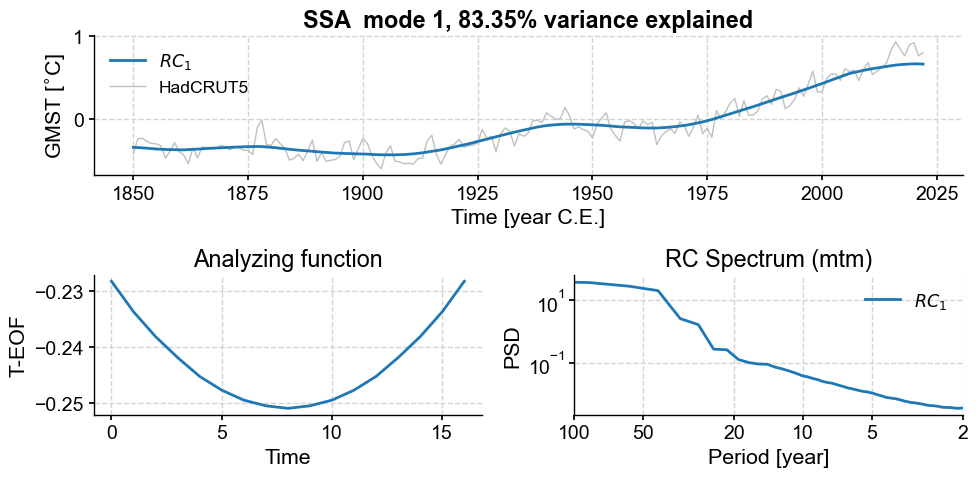

In [30]:
gmst_ssa.modeplot(index=0)

To remove this mode from the original series, you would do:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year C.E.]', ylabel='GMST [$^{\\circ}$C]'>)

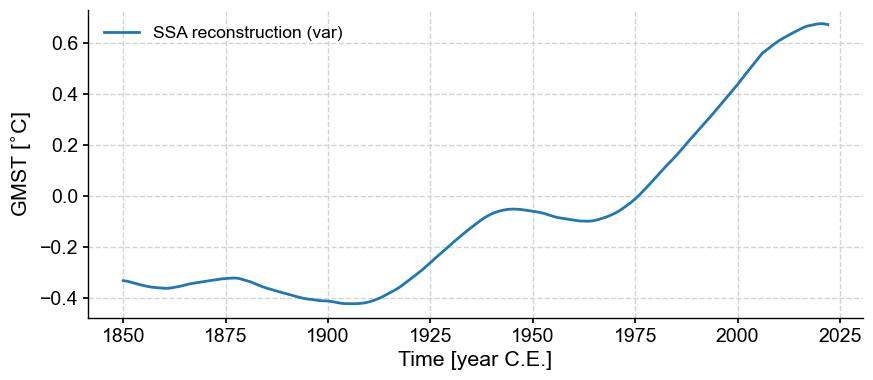

In [31]:
gmst_ssa = gmst.ssa(trunc='var') # this will select the mode(s) that account for a certain fraction of variance, here 80% by default. 
ssa_trend = gmst_ssa.RCseries
ssa_trend.plot()

<Axes: xlabel='Time [year C.E.]', ylabel='GMST [$^{\\circ}$C]'>

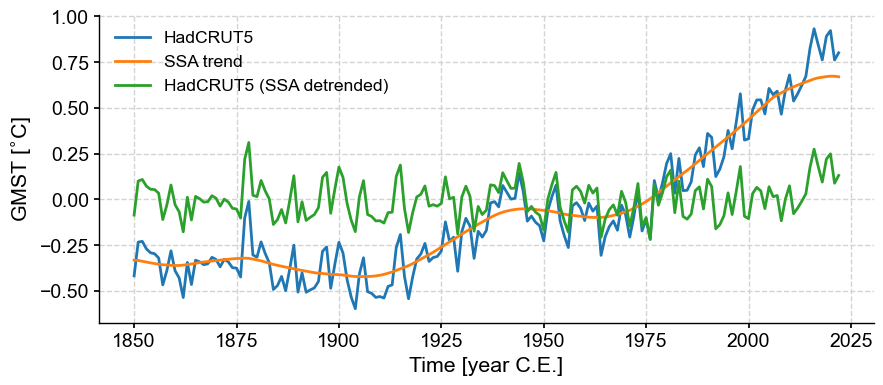

In [36]:
gmst_ssa_dtd = gmst.copy() # copy the original
gmst_ssa_dtd.value = gmst.value - ssa_trend.value # remove SSA trend from original
gmst_ssa_dtd.label = gmst.label + ' (SSA detrended)'
fig, ax = gmst.plot()
ssa_trend.plot(ax=ax,label='SSA trend')
gmst_ssa_dtd.plot(ax=ax)

This pre-processing allows to better isolate oscillatory behavior. To see this, let's look at the [spectra](http://linked.earth/PyleoTutorials/notebooks/L2_spectral_analysis.html) of the original and detrended versions:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [year]', ylabel='PSD'>)

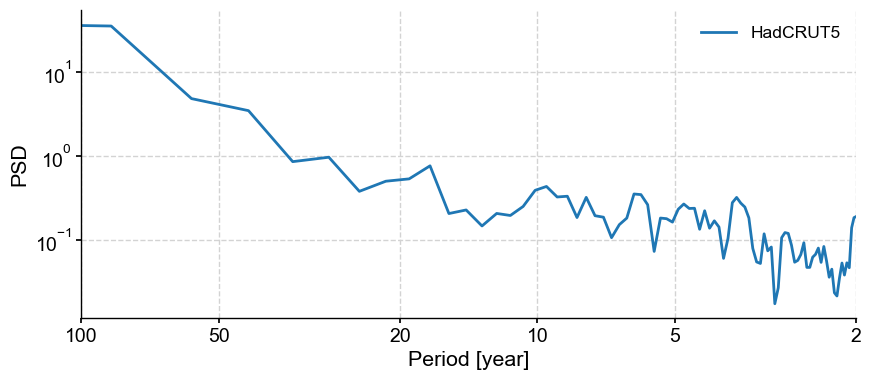

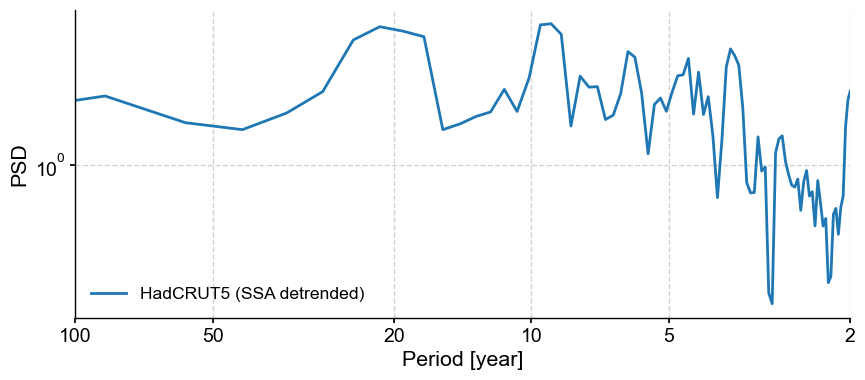

In [37]:
gmst.spectral(method='mtm',settings={'NW':2}).plot()
gmst_ssa_dtd.spectral(method='mtm',settings={'NW':2}).plot()

We see that detrending has removed much of the variability at scales longer than ~30y, allowing to hone in on various peaks near 3.5, 6, 10 and 20 years. To see if those are significant, however, you would need to apply `signif_test()`, which we illustrate in [another tutorial](./Spectral_Analysis_Rio_Grande.md).

## Takeways

- `Pyleoclim` enables easy filtering and detrending
- **Interactive visualization is a key part of the process**, to make sure that the signal processing is achieving what it is supposed to do.